In [14]:
import scipy.stats as st
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [15]:
def f(x, y):
    z = np.column_stack([x.ravel(), y.ravel()])
    return (0.1*st.multivariate_normal([0,0], 1*np.eye(2)).pdf(z) +
            0.4*st.multivariate_normal([3,3], 2*np.eye(2)).pdf(z) +
            0.5*st.multivariate_normal([0,5], 3*np.eye(2)).pdf(z))

In [16]:
f(np.arange(3), np.arange(3))

array([ 0.01668036,  0.01172299,  0.02263674])

In [17]:
s = 200
x = np.linspace(-3, 6, s)
y = np.linspace(-3, 8, s)
X, Y = np.meshgrid(x, y)
Z = np.reshape(f(X, Y), (s, s))

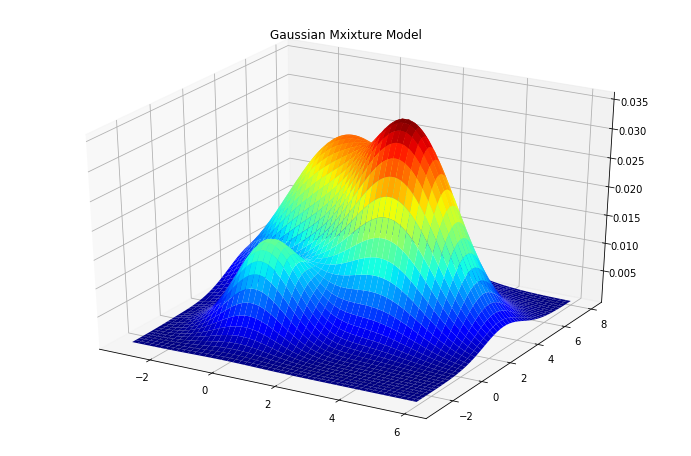

In [18]:
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(12,8))
ax = fig.add_subplot(111, projection='3d')
ax.plot_surface(X, Y, Z, cmap='jet')
plt.title('Gaussian Mxixture Model');

In [19]:
from scipy.stats import multivariate_normal as mvn

In [20]:
def em_gmm_orig(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(len(mus)):
            for i in range(n):
                ws[j, i] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
        ws /= ws.sum(0)

        # M-step
        pis = np.zeros(k)
        for j in range(len(mus)):
            for i in range(n):
                pis[j] += ws[j, i]
        pis /= n

        mus = np.zeros((k, p))
        for j in range(k):
            for i in range(n):
                mus[j] += ws[j, i] * xs[i]
            mus[j] /= ws[j, :].sum()

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            for i in range(n):
                ys = np.reshape(xs[i]- mus[j], (2,1))
                sigmas[j] += ws[j, i] * np.dot(ys, ys.T)
            sigmas[j] /= ws[j,:].sum()

        # update complete log likelihoood
        ll_new = 0.0
        for i in range(n):
            s = 0
            for j in range(k):
                s += pis[j] * mvn(mus[j], sigmas[j]).pdf(xs[i])
            ll_new += np.log(s)

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

In [21]:
np.random.seed(123)

# create data set
n = 1000
_mus = np.array([[0,4], [-2,0]])
_sigmas = np.array([[[3, 0], [0, 0.5]], [[1,0],[0,2]]])
_pis = np.array([0.6, 0.4])
xs = np.concatenate([np.random.multivariate_normal(mu, sigma, int(pi*n))
                    for pi, mu, sigma in zip(_pis, _mus, _sigmas)])

# initial guesses for parameters
pis = np.random.random(2)
pis /= pis.sum()
mus = np.random.random((2,2))
sigmas = np.array([np.eye(2)] * 2)

In [28]:
%%time
ll1, pis1, mus1, sigmas1 = em_gmm_orig(xs, pis, mus, sigmas)

CPU times: user 10.7 s, sys: 54.9 ms, total: 10.7 s
Wall time: 10.8 s


/Users/abdulla/anaconda2/envs/py36/lib/python3.6/site-packages/matplotlib/contour.py:967: UserWarning: The following kwargs were not used by contour: 'N'
  s)


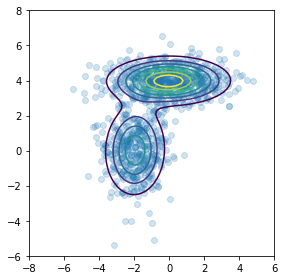

In [34]:
intervals = 101
ys = np.linspace(-8,8,intervals)
X, Y = np.meshgrid(ys, ys)
_ys = np.vstack([X.ravel(), Y.ravel()]).T

z = np.zeros(len(_ys))
for pi, mu, sigma in zip(pis1, mus1, sigmas1):
    z += pi*mvn(mu, sigma).pdf(_ys)
z = z.reshape((intervals, intervals))

ax = plt.subplot(111)
plt.scatter(xs[:,0], xs[:,1], alpha=0.2)
plt.contour(X, Y, z, N=10)
plt.axis([-8,6,-6,8])
ax.axes.set_aspect('equal')
plt.tight_layout()

In [35]:
def em_gmm_eins(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j, (pi, mu, sigma) in enumerate(zip(pis, mus, sigmas)):
            ws[j, :] = pi * mvn(mu, sigma).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = np.einsum('kn->k', ws)/n
        mus = np.einsum('kn,np -> kp', ws, xs)/ws.sum(1)[:, None]
        sigmas = np.einsum('kn,knp,knq -> kpq', ws,
            xs-mus[:,None,:], xs-mus[:,None,:])/ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

In [39]:
def em_gmm_vect(xs, pis, mus, sigmas, tol=0.01, max_iter=100):

    n, p = xs.shape
    k = len(pis)

    ll_old = 0
    for i in range(max_iter):
        exp_A = []
        exp_B = []
        ll_new = 0

        # E-step
        ws = np.zeros((k, n))
        for j in range(k):
            ws[j, :] = pis[j] * mvn(mus[j], sigmas[j]).pdf(xs)
        ws /= ws.sum(0)

        # M-step
        pis = ws.sum(axis=1)
        pis /= n

        mus = np.dot(ws, xs)
        mus /= ws.sum(1)[:, None]

        sigmas = np.zeros((k, p, p))
        for j in range(k):
            ys = xs - mus[j, :]
            sigmas[j] = (ws[j,:,None,None] * mm(ys[:,:,None], ys[:,None,:])).sum(axis=0)
        sigmas /= ws.sum(axis=1)[:,None,None]

        # update complete log likelihoood
        ll_new = 0
        for pi, mu, sigma in zip(pis, mus, sigmas):
            ll_new += pi*mvn(mu, sigma).pdf(xs)
        ll_new = np.log(ll_new).sum()

        if np.abs(ll_new - ll_old) < tol:
            break
        ll_old = ll_new

    return ll_new, pis, mus, sigmas

In [37]:
%%time
ll3, pis3, mus3, sigmas3 = em_gmm_eins(xs, pis, mus, sigmas)

CPU times: user 36.4 ms, sys: 1.37 ms, total: 37.8 ms
Wall time: 40.1 ms
